In [16]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
from time import time

# Chapter 2 Practical Works

### Exercise 1 
Consider the Tikhonov regularization problem given by
$$\min\limits_{x\in\mathbb{R}^d} f(x) = \dfrac{1}{2}\|Ax-b\|^2 + \dfrac{\gamma}{2}\|x\|^2.$$

In [221]:
np.random.seed(42) 
n, d = 100, 50 
A = np.random.randn(n, d) 
b = np.random.randn(n, 1)

gamma = 0.5

g = lambda x: norm(A@x - b)**2/2

# Choose the optimal lambda
L = np.linalg.norm(A.T @ A, 2)
_lambda = 1/L

#### 1. Discuss the objective of the Tikhonov regularization problem, and give an interpretation of the parameter 

We can interpret the regularizer $\dfrac{\gamma}{2}\|x\|^2$ as to penalize on the norm of $x$. In other words, it forces the solution to have smaller norm. When $\gamma$ is large, the penalization is more intense.

#### 2. Solve the problem using Gradient descent, Proximal point, Proximal gradient and Douglas-Rachford algorithms

We will work on the generalized problem where

$$f(x) = \dfrac{1}{2}\|Ax-b\|^2 + \dfrac{1}{2}\|Bx\|^2.$$

 In the special case, we have $B^\top B = \gamma I$. Let
    $$g(x) = \dfrac{1}{2}\|Ax-b\|^2$$
    and 
    $$h_2(x) = \dfrac{1}{2}\|Bx\|^2.$$

In [18]:
h2 = lambda x: gamma*norm(x)/2
f = lambda x: g(x) + h2(x)

##### Gradient descent

We have
$$\nabla g(x) = A^\top (Ax- b), \nabla h_2(x) = B^\top Bx.$$

Hence, we can compute $\nabla f(x) = \nabla g(x) + \nabla h_2(x)$.


In [19]:
grad_g = lambda x: A.T@(A@x-b)
grad_h2 = lambda x: gamma*x

grad_f = lambda x: grad_g(x) + grad_h2(x)

In [20]:
def gradient_descent(f, grad_f, 
                     x0=np.random.randn(n,1), 
                     lr=0.0001, tol = 0.1, max_iter = int(1e6),
                     plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = x - lr*grad_f(x)
    history.append(x_new)

    diff = np.abs(f(x) - f(x_new))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break

    x = x_new

  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
    

  return x

Terminated after 372 iterations. Time: 0.014549732208251953s
Final difference: 0.09921318389296374


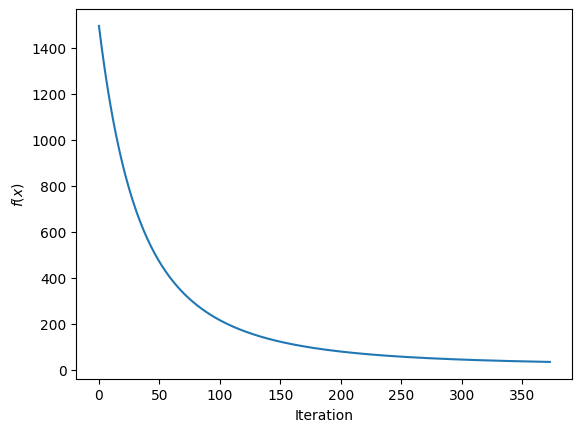

In [21]:
x_opt = gradient_descent(f, grad_f)

##### Proximal point
We have
$$\begin{aligned}
y\in \mathrm{prox}_{\lambda f} (x) 
& \Leftrightarrow x = y + \nabla f(y) \\
& \Leftrightarrow x = y + \lambda(A^\top (Ay- b) + B^\top By) \\
& \Leftrightarrow \dfrac{1}{\lambda}x = \dfrac{1}{\lambda}y + (A^\top A+B^\top B)y - A^\top b \\
& \Leftrightarrow y = \left(A^\top A + B^\top B + \dfrac{1}{\lambda}I\right)^{-1}\left(A^\top b+\dfrac{1}{\lambda}x\right).
\end{aligned}$$


In [22]:
def prox_f(x):
    return inv(A.T@A + (gamma + 1/_lambda)*np.eye(n))@(A.T@b + x/_lambda)

In [23]:
def proximal_point(f, prox_f, 
                   x0 = np.random.randn(n,1), 
                   tol=1e-6, max_iter=int(1e6), plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = prox_f(x)

    history.append(x_new)
    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time() - start}s")
      print(f"Final difference: {diff}")
      break


    x = x_new

  if iter == max_iter - 1: print(f"Reached maximal {iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
  return x

Terminated after 151 iterations. Time: 0.0864102840423584s
Final difference: 9.69767150138523e-07


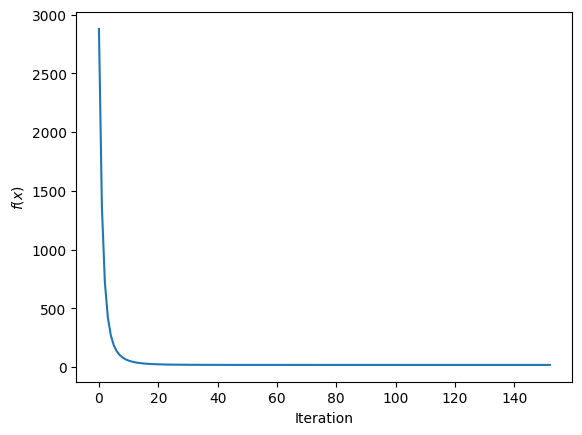

In [24]:
x_opt = proximal_point(f, prox_f)

##### Proximal gradient

We have $\mathrm{prox}_{\lambda h_2}(x) = \dfrac{1}{1+\lambda\gamma}(x)$

In [25]:
def proximal_gradient(f,  
                      grad_g, prox_h, 
                      x0 = np.random.randn(n,1), 
                      tol = 1e-6, max_iter=int(1e6), plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = prox_h(x - _lambda*grad_g(x))

    history.append(x_new)
    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break
    
    x = x_new

  if iter == max_iter - 1: print(f"Reached maximal {iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()

  return x

Terminated after 153 iterations. Time: 0.009921550750732422s
Final difference: 9.697842955347369e-07


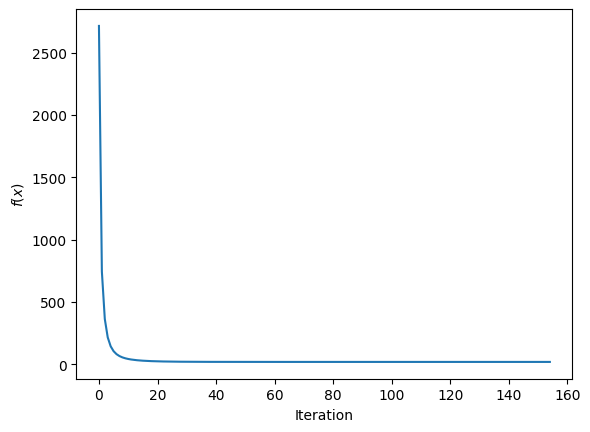

In [26]:
prox_h2 = lambda x: x/(1+_lambda*gamma)
x_opt = proximal_gradient(f, grad_g, prox_h2)

##### Douglas-Rachford
We have $\mathrm{prox}_{\lambda g}(x) = \left(A^\top A + \dfrac{1}{\lambda} I\right)^{-1}\left(A^\top b + \dfrac{1}{\lambda}x\right)$.

Therefore, $\mathrm{refl}_{\mathrm{prox}_{\lambda g}}(x) = 2\mathrm{prox}_{\lambda g}(x)-x$ and $\mathrm{refl}_{\mathrm{prox}_{\lambda h_2}}(x) = (1-2\lambda\gamma)x$

In [27]:
def douglas_rachford(f, 
                     prox_g, refl_g, refl_h, 
                     y0 = np.random.randn(A.shape[1],1),
                     tol = 1e-6, max_iter=int(1e6), plot=True):
  start = time()
  y = y0
  x = prox_g(y)
  history = [x]

  for iter in range(max_iter):
    y = (y + refl_h(refl_g(y)))/2
    x_new = prox_g(y)

    history.append(x_new)

    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break
   
    x = x_new
  
  if iter == max_iter - 1: print(f"Reached maximal {max_iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
  return x

Terminated after 122 iterations. Time: 0.07211875915527344s
Final difference: 8.660540835592201e-07


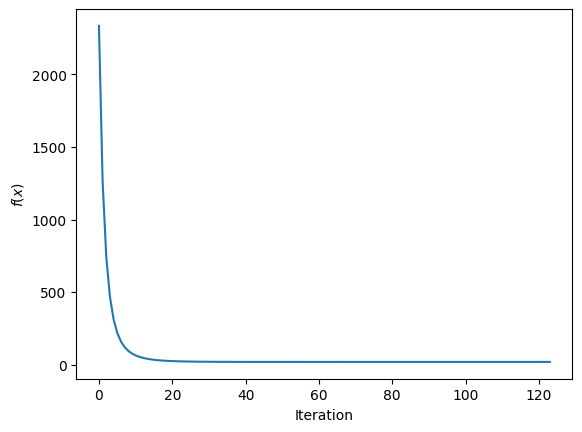

In [28]:
h2 = lambda x: gamma*norm(x)/2
f = lambda x: g(x) + h2(x)

def prox_g(x):
  return inv(A.T@A + np.eye(n)/_lambda)@(A.T@b + x/_lambda)

def refl_g(x):
  return 2*prox_g(x) - x


def refl_h2(x):
  return 2*prox_h2(x) - x

x_opt = douglas_rachford(f, prox_h2, refl_h2, refl_g)

#### 3. Compare the convergence rates of the four codes.

It is not plausible to compare Gradient descent with the others because the meaning of learning rates are different. Among, Proximal point, Proximal gradient and Douglas-Rachford's with optimal learning rate $\lambda = \dfrac{1}{L}$, using that $g$ is $L$-Lipschitz, we can see that Proximal gradient consume least time, as it makes uses of both gradient and proximity comparing to Proximal point, while computes less that Douglas-Rachford's in each iteration.

#### 4. Provide a code to solve the general problem

We shall use gradient descent

Terminated after 256 iterations. Time: 0.06167101860046387s
Final difference: 0.09897459575177692


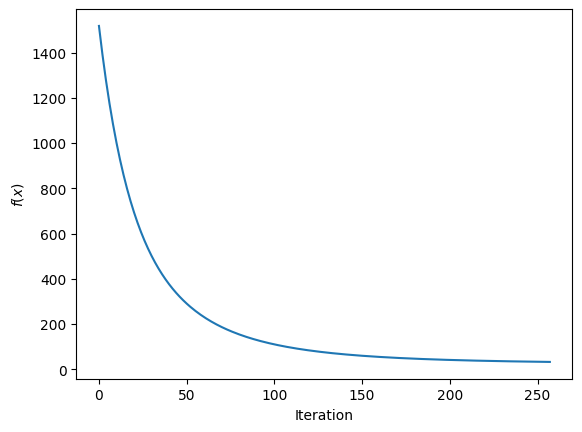

In [29]:
p = 50
B = np.random.randn(p, n)

h2 = lambda x: norm(B@x)/2
grad_h2 = lambda x: B.T@B@x

f = lambda x: g(x) + h2(x)
grad_f = lambda x: grad_g(x) + grad_h2(x)

x_opt = gradient_descent(f, grad_f)

#### 5. Discuss the objective of the generalized Tikhonov regularization problem, and give an interpretation of the matrix $B$.

The use of a matrix instead of a constant raises more flexibility for regularization. This can be applied when we especially want to to enforce smoothness if the underlying vector is believed to be mostly continuous.

### Exercise 2

Consider the LASSO problem

$$\min\limits_{x\in\mathbb{R}^d} \dfrac{1}{2}\|Ax-b\|^2 + \gamma\|x\|_1,$$
where $A\in\mathbb{R}^{n\times d}$ and $\gamma > 0$.

#### 1. Why is the last term $\gamma\|x\|_1$ usually call the sparsity enforcement? Make a drawing in the two-dimensional case.

Like the $\ell_2$-norm, the $\ell_1$-norm penalizes on the largeness of each component of the considered vector $x$. But the penalization is the same of each element greater than $1$. So it can be interpreted as enforcing the elements to be 0 (rather than closer to 0 as the $\ell_2$-norm). The more elements equal to $0$, $x$ is called more sparse. That is the reason why $\ell_1$-norm penalization is called sparsity enforcement.

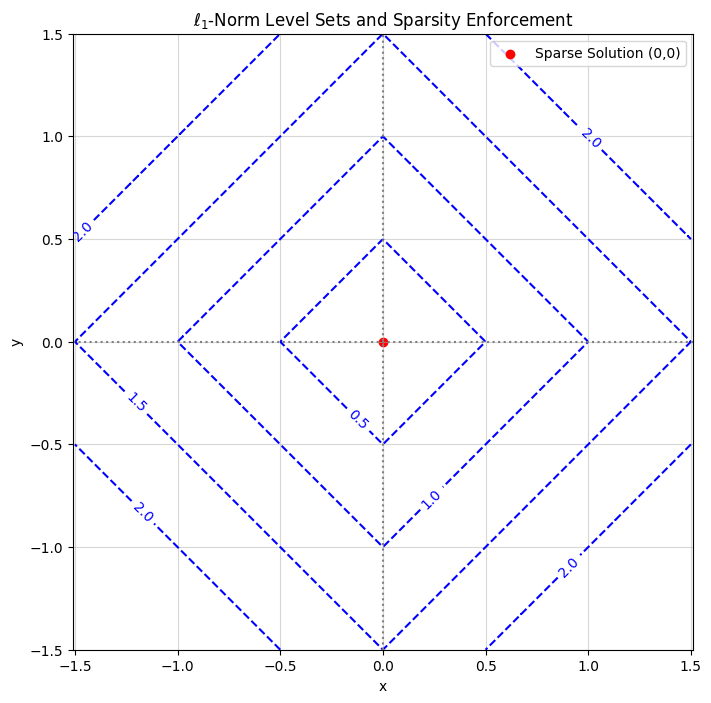

In [220]:
# Create a grid for plotting
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

# Define the \ell_1-norm level set function
L1_norm = np.abs(X) + np.abs(Y)

# Plot the level sets of the \ell_1-norm
plt.figure(figsize=(8, 8))
contour = plt.contour(X, Y, L1_norm, levels=[0.5, 1, 1.5, 2], colors='blue', linestyles='--')
plt.clabel(contour, inline=True, fontsize=10, fmt="%.1f")

# Mark the sparsity-promoting axis intersections
plt.axhline(0, color='gray', linestyle=':')
plt.axvline(0, color='gray', linestyle=':')
plt.scatter([0], [0], color='red', label="Sparse Solution (0,0)")

# Add labels and title
plt.title(r"$\ell_1$-Norm Level Sets and Sparsity Enforcement")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.5)
plt.axis('equal')

# Show the plot
plt.show()

####
1. Why is the last term $\gamma\|x\|_1$ usually called the sparsity enforcement? Make a drawing in the two-dimensional case for illustration.
2. Discuss the objective of the LASSO problem, and give an interpretation of the parameter.

  
  As the name LASSO (Least Absolute Shrinkage and Selection Operator) suggests, the term "sparsity enforcement" reflects LASSO's ability to encourage simpler models with fewer active features, which is particularly valuable in high-dimensional datasets. In other words, it forces as many as possible numbers of features to be zero. As $\gamma$ is larger, the selection enforcement is more intense.

#### 3. Solve the problem using Proximal gradient and Douglas-Rachford

##### Proximal gradient

Let $h_1 = \gamma\|x\|_1$. We have $\mathrm{prox}_{\lambda h_1}(x)_i = \mathrm{sign}(x_i)\max(|x_i|-\lambda\gamma, 0)$.

In [31]:
def soft_threshold(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)

Terminated after 113 iterations. Time: 0.00496363639831543s
Final difference: 9.740356361476188e-07


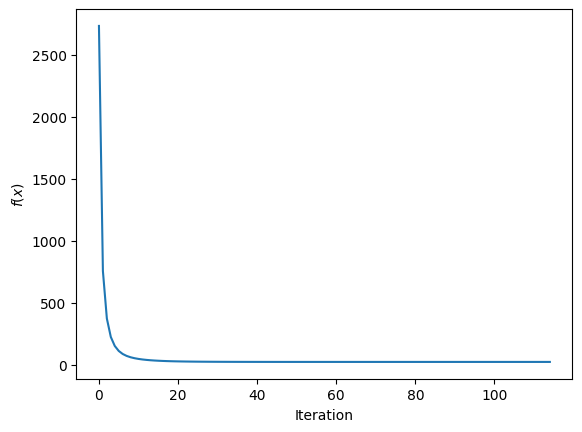

In [32]:
h1 = lambda x: gamma*norm(x, 1)
prox_h1 = lambda x: soft_threshold(x, gamma*_lambda)
f = lambda x: g(x) + h1(x)

L = np.linalg.norm(A.T @ A, 2)
_lambda = 1/L

x_opt = proximal_gradient(f, grad_g, prox_h1)

##### Douglas-Rachford

Terminated after 124 iterations. Time: 0.2317945957183838s
Final difference: 9.908578775252863e-07


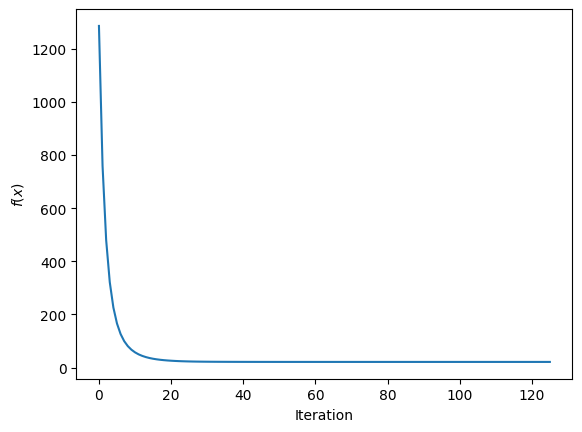

In [33]:
refl_h1 = lambda x: 2*prox_h1(x) - x
x_opt = douglas_rachford(f, prox_g, refl_g, refl_h1)

#### 4. Compare to algorithms

Similarly to Exercise 1, this class of function is small for Douglas-Rachford to take effect. The cost of each iteration in Douglas-Rachford overcomes the number of iterations. In our case, Douglas-Rachford also takes more iterations than Proximal gradient. Hence the time is far more than Proximal gradient's.

#### 5. Provide a code allowing to solve the generalized LASSO

$$\min\limits_{x\in\mathbb{R}^d} \dfrac{1}{2}\|Ax-b\|^2 + \|Bx\|_1,$$

where $A\in\mathbb{R}^{n\times d}$, $B\in\mathbb{R}^{m\times d}$, and $b\in\mathbb{R}^n$.

We use the idea from Exercise 3. Let $y = Bx\in \mathbb{R}^m$, the problem becomes minimizing $f(x,y) + g(x,y) + h(x,y)$, where

$$f(x,y) = \|y\|_1,$$

$$g(x,y) = \iota_{\{y = Bx\}(x,y)}$$

$$h(x,y) = \dfrac{1}{2}\|Ax-b\|^2.$$

Then we use the Davis-Yin algorithm.

In [261]:
m = 25
B = np.random.randn(m, d)

def indicator(cond, x):
  if cond(x): return 0
  return 1e16

epsilon = 1e-5

f = lambda x: norm(x[d:], 1)
prox_f = lambda x: np.vstack([np.zeros((d,1)), 
                              soft_threshold(x[d:], _lambda*gamma)])

g = lambda x: indicator(lambda x: norm(x[d:] - B@x[:d]) < epsilon, x)
prox_g = lambda x: np.vstack([x[:d], B@x[:d]])

h = lambda x: norm(A@x[:d] - b, 2)**2/2
grad_h = lambda x: np.vstack([A.T@(A@x[:d] - b), np.zeros((m, 1))])

In [ ]:
def davis_yin(f, g, h,
              prox_f, prox_g, grad_h, max_iter=10000, plot=True):
  y = np.random.randn(d+m, 1)
  history = []

  for _ in range(max_iter):
    x = prox_f(y)
    history.append(x)
    y_new = y - x + prox_g(2*x - y - _lambda*grad_h(x))
    y = y_new  

    print(f"f: {f(x)}, g: {g(x)}, h: {h(x)}")
  
  if plot:
    plt.plot([np.log(f(x) + g(x) + h(x)) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel(r'$\log\circ(f + g + h)$')

    plt.show()

  return history[-1]

(75, 1) (75, 1)
f: 20.79204599314321, g: 1e+16, h: 50.576048795734756
(75, 1) (75, 1)
f: 169.5301923431001, g: 1e+16, h: 50.576048795734756
(75, 1) (75, 1)
f: 4.135147085859714e-15, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (75, 1)
f: 0.0, g: 0, h: 50.576048795734756
(75, 1) (7

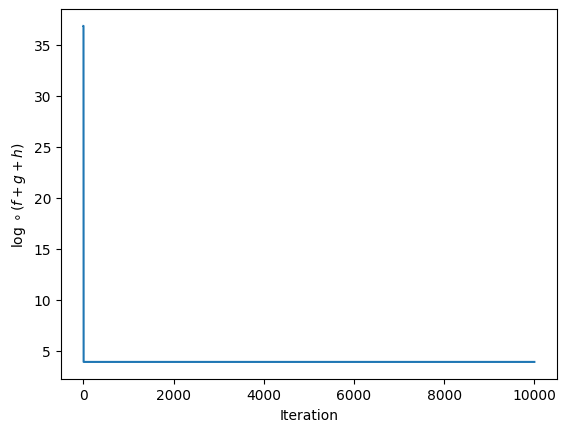

In [264]:
_lambda = 1/L
gamma = 1
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

6. Discuss the objective of the generalized LASSO and give an interpretation of $B$.

Similarly to Ridge, $B$ give more flexibility to the enforcement. Instead of forcing each element of a vector to be zero, we can force some expressions of the elements of the vector to be zero.

### Exercise 3



In [108]:
b = plt.imread(r"blurred.jpg").reshape(-1, 1)

#### 3. Explain why the above optimization problem is suitable for deblurring.

By using this objective function, we hypothesized that the original image has continuous gradient (difference between adjacent pixels). The first element is to find the nearest image, the second element is for continuous gradient hypothesis.

#### 4. Construct $F$

We write $F = \begin{pmatrix}F_1\\F_2\end{pmatrix}$, where $F_1,F_2\in\mathbb{R}^{100\times100}$ and $\|F_1\|/_1=\sum\limits_{i=1}^{100} |x_i - x_{\mathrm{ho(i)}|}$ and $\|F_2\|_=\sum\limits_{i=1}^{100} |x_i - x_{\mathrm{ve(i)}|}$. Now we consider the rows of each sub-matrix.

For $F_1$, the rows corresponding to right-most pixels i.e. $x_i$ such that $i \mod 10 = 9$ (indexing from 0 to 99) contain all zeros. Other rows $i$ have the $i$-th element to be $1$ and the $(i+1)$-th element to be $-1$.

For $F_2$, the last rows will be all zeros. Other rows $i$ have the $i$-th element to be $1$ and the $(i+10)$-th element to be $-1$.

In [35]:
F1 = np.zeros([100, 100])

for i in range(100):
  if i % 10 != 9:
    F1[i, i] = 1
    F1[i, i+1] = -1

F2 = np.zeros([100, 100])

for i in range(100):
  if i < 90:
    F2[i, i] = 1
    F2[i, i+10] = -1

F = np.vstack([F1, F2])

#### 5. Redefine the problem in terms of a sum of three functions

Let $y = Fx$ and

$$f_1(x) = \iota_{x\in[0, 255]}(x), f_2(y) = \gamma\|y\|_1,$$
$$g(x,y) = \iota_{\{y = Fx\}}(x,y),$$
$$h(x,y) = \dfrac{1}{2}\|x-b\|^2.$$

#### 6. Provide analytical form of the proximities
Note that an indicator function does not change under constant multiplication. We have
$$\mathrm{prox}_{\lambda f_1}(x) = \mathrm{prox}_{f_1}(x) = \mathrm{proj}_{[0,255]}(x) = \min\{\max\{x_i,0\}, 255\}.$$

According to Exercise 2, $\mathrm{prox}_{\lambda f_2}(x) = \mathrm{SoftThreshold}(x, \lambda\gamma)$.
Furthermore, 
$$\begin{aligned}
\mathrm{prox}_{\lambda(f_1+f_2)}(x_0,y_0) 
& = \argmin\limits_{x,y}\left(\lambda f_1(x) + \lambda f_2(y) + \dfrac{1}{2}\left\|\begin{pmatrix}x\\y\end{pmatrix} - \begin{pmatrix}x_0\\y_0\end{pmatrix}\right\|\right) \\
& = \argmin\limits_{x,y}\left(\lambda f_1(x) + \lambda f_2(y) + \dfrac{1}{2}\|x-x_0\|^2 + \dfrac{1}{2}\|y-y_0\|^2 \right) \\
& = \begin{bmatrix}
\argmin\limits_{x}\left(\lambda f_1(x) + \dfrac{1}{2}\|x-x_0\|^2 \right) \\ \argmin\limits_{y}\left(\lambda f_2(y) + \dfrac{1}{2}\|y-y_0\|^2 \right)
\end{bmatrix} 
\\
& = \begin{bmatrix}
\mathrm{prox}_{\lambda f_1}(x_0) \\
\mathrm{prox}_{\lambda f_2}(y_0)
\end{bmatrix}.
\end{aligned}$$

On the other hand,
$$\mathrm{prox}_{g}(x_0, y_0) = \mathrm{proj}_{\{y = Fx\}}(x_0,y_0) = \begin{pmatrix}x_0 \\ Fx_0\end{pmatrix} .$$

Finally, $\nabla h(x_0) = \begin{pmatrix}x-b \\ 0\end{pmatrix} $.

In [189]:
def indicator(cond, x):
  if cond(x): return 0
  return 1e16

In [160]:
epsilon = 1e-5

f1 = lambda x: indicator(lambda x: np.all(x >= 0) and np.all(x <= 255), x)
f2 = lambda y: gamma*norm(y,1)
f = lambda x: f1(x[:100]) + f2(x[100:])
prox_f = lambda x: np.vstack([np.minimum(np.maximum(x[:100], 0), 255), soft_threshold(x[100:], _lambda*gamma)])

g = lambda x: indicator(lambda x: norm(x[100:] - F@x[:100]) < epsilon, x)
prox_g = lambda x: np.vstack([x[:100], F@x[:100]])

h = lambda x: norm(x[:100] - b, 2)**2/2
grad_h = lambda x: np.vstack([x[:100] - b, np.zeros((200, 1))])

#### 7.8. Solve the problem using Davis-Yin algorithm.

Let $f,g\in\Gamma_0(\mathbb{R}^d)$ and $h$ be convex, $L$-smooth. For any $0 < \lambda < \dfrac{2}{L}$, define the operator

$$\mathcal{T} = \mathrm{Id} - \mathrm{prox}_{\lambda f} + prox_{\lambda g}\circ \left(2\mathrm{prox}_{\lambda f} - \mathrm{Id} - \lambda \nabla h\circ \mathrm{prox}_{\lambda f} \right).$$

Then the sequence defined by $y_0\in\mathbb{R}^d$ and $y_{n+1} = \mathcal{T}(y_n)$ for $n\ge 1$ converges to a point in $\mathrm{Fix}(\mathcal{T})$, and $x = \mathrm{prox}_{\lambda f}(y)\in \mathrm{Argmin}(f+g+h)$.


In [ ]:
y = np.random.randint(0, 256, (300, 1))
prox_f(y)

In [ ]:
def davis_yin(f, g, h,
              prox_f, prox_g, grad_h, max_iter=10000, plot=True):
  y = np.random.randint(0, 256, (300, 1))
  history = []

  for _ in range(max_iter):
    x = prox_f(y)
    history.append(x)
    y_new = y - x + prox_g(2*x - y - _lambda*grad_h(x))
    y = y_new  

    print(f"f1: {f1(x[:100])}, f2: {f2(x[100:])}, g: {g(x)}, h: {h(x)}")
  
  if plot:
    plt.plot([np.log(f(x) + g(x) + h(x)) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel(r'$\log\circ(f + g + h)$')

    plt.show()

  return history[-1]

f1: 0, f2: 25824.050000000003, g: 1e+16, h: 651366.5000000002
f1: 0, f2: 15350.149999999998, g: 1e+16, h: 587858.2662500002
f1: 0, f2: 14684.7925, g: 1e+16, h: 530542.085290625
f1: 0, f2: 14045.667000000001, g: 1e+16, h: 478814.2319747892
f1: 0, f2: 13450.604775, g: 0, h: 432129.8443572473
f1: 0, f2: 12885.17453625, g: 0, h: 389997.1845324155
f1: 0, f2: 12348.0158094375, g: 0, h: 351972.459040505
f1: 0, f2: 11848.68817462656, g: 1e+16, h: 317655.14428405574
f1: 0, f2: 11402.994821303517, g: 1e+16, h: 286683.7677163604
f1: 0, f2: 10996.441349403918, g: 1e+16, h: 258732.10036401523
f1: 0, f2: 10635.066958538726, g: 1e+16, h: 233505.72057852385
f1: 0, f2: 10311.57855063209, g: 1e+16, h: 210738.9128221177
f1: 0, f2: 10030.577159844972, g: 1e+16, h: 190191.86882196116
f1: 0, f2: 9772.929318658205, g: 1e+16, h: 171648.16161182002
f1: 0, f2: 9534.351255899735, g: 1e+16, h: 154912.4658546675
f1: 0, f2: 9341.110808658468, g: 1e+16, h: 139808.50043383744
f1: 0, f2: 9176.542346534243, g: 1e+16, h

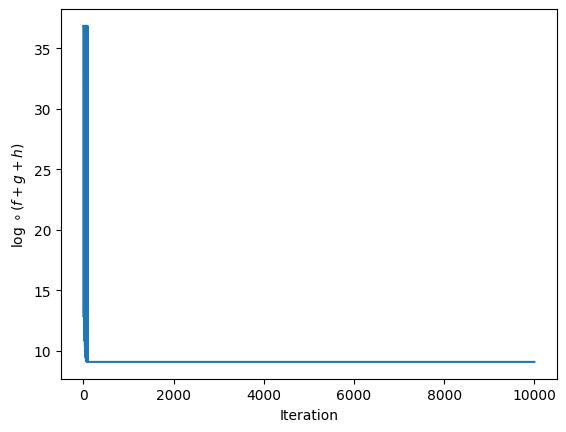

Sum of squares of difference: 2.570827794705853e-12


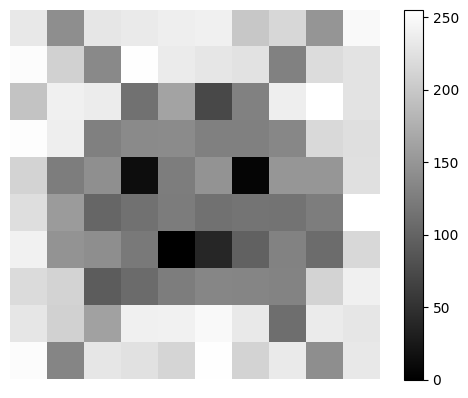

In [191]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 1
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


f1: 0, f2: 247645.0, g: 1e+16, h: 528515.9999999999
f1: 0, f2: 149186.49999999997, g: 1e+16, h: 476985.68999999994
f1: 0, f2: 143233.425, g: 0, h: 430479.58522499993
f1: 0, f2: 136913.56875, g: 1e+16, h: 388507.8256655625
f1: 0, f2: 131043.2949375, g: 1e+16, h: 350628.31266317016
f1: 0, f2: 125485.49444062497, g: 0, h: 316442.052178511
f1: 0, f2: 120343.40221359374, g: 1e+16, h: 285588.95209110616
f1: 0, f2: 115686.98386960155, g: 1e+16, h: 257744.02926222337
f1: 0, f2: 111342.02183181132, g: 1e+16, h: 232613.98640915655
f1: 0, f2: 107432.44325966705, g: 1e+16, h: 209934.12273426374
f1: 0, f2: 104044.07766744531, g: 1e+16, h: 189465.545767673
f1: 0, f2: 100952.12910307277, g: 1e+16, h: 170992.65505532495
f1: 0, f2: 98245.88350804648, g: 1e+16, h: 154320.87118743075
f1: 0, f2: 95924.22799155989, g: 1e+16, h: 139274.58624665625
f1: 0, f2: 93916.51659198193, g: 0, h: 125695.31408760726
f1: 0, f2: 92065.55081634314, g: 1e+16, h: 113440.02096406555
f1: 0, f2: 90559.79645551617, g: 1e+16, h:

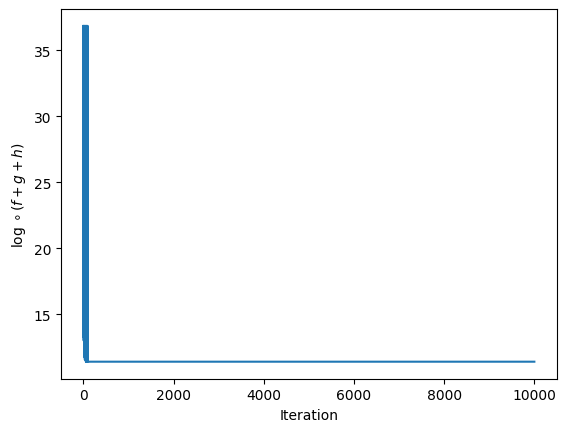

Sum of squares of difference: 2.555068725756223e-12


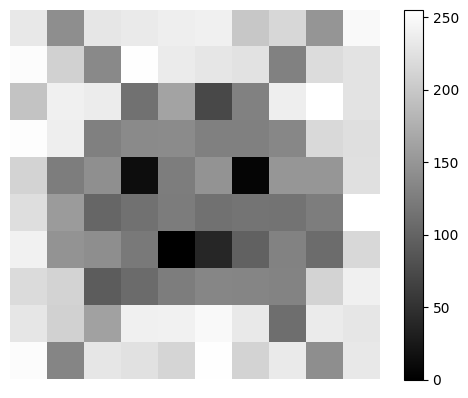

In [192]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 10
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


f1: 0, f2: 2281100.0, g: 1e+16, h: 498144.0
f1: 0, f2: 1382745.0, g: 1e+16, h: 449574.95999999996
f1: 0, f2: 1391227.0, g: 1e+16, h: 405741.4014000001
f1: 0, f2: 1325558.4, g: 1e+16, h: 366181.61476349994
f1: 0, f2: 1265506.54625, g: 1e+16, h: 330478.9073240588
f1: 0, f2: 1210150.70534375, g: 1e+16, h: 298257.213859963
f1: 0, f2: 1159372.5836515625, g: 1e+16, h: 269177.1355086166
f1: 0, f2: 1114658.1244146875, g: 1e+16, h: 242932.36479652653
f1: 0, f2: 1074534.6410946015, g: 1e+16, h: 219246.45922886507
f1: 0, f2: 1037880.5846176783, g: 1e+16, h: 197869.92945405073
f1: 0, f2: 1002594.3833183581, g: 1e+16, h: 178577.61133228088
f1: 0, f2: 972531.8708301741, g: 1e+16, h: 161166.2942273834
f1: 0, f2: 944185.3816713109, g: 1e+16, h: 145452.58054021362
f1: 0, f2: 918879.8129061684, g: 1e+16, h: 131270.9539375427
f1: 0, f2: 895613.4544294862, g: 1e+16, h: 118472.03592863232
f1: 0, f2: 876987.9180999942, g: 1e+16, h: 106921.01242559067
f1: 0, f2: 862714.0415873728, g: 1e+16, h: 96496.21371409

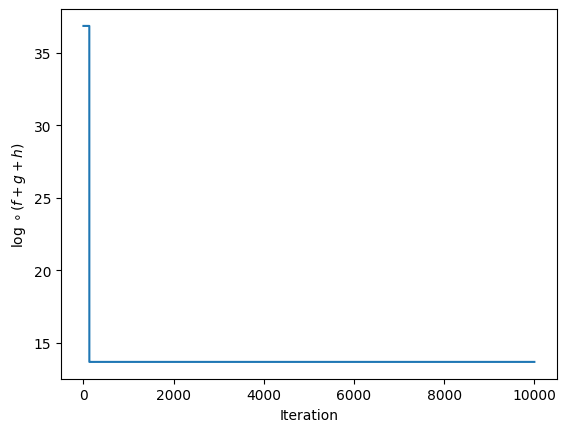

Sum of squares of difference: 2.570827794705853e-12


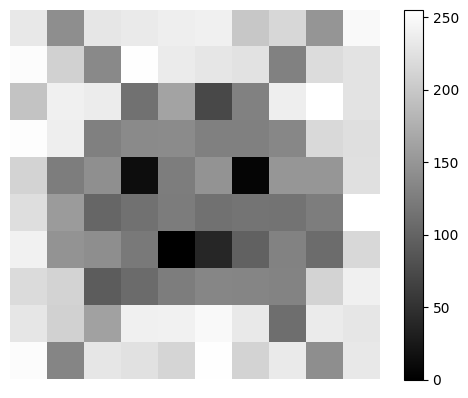

In [193]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 100
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


f1: 0, f2: 5117800.0, g: 1e+16, h: 572518.0
f1: 0, f2: 2498430.0, g: 1e+16, h: 516697.4949999999
f1: 0, f2: 2685885.0, g: 1e+16, h: 466319.48923749995
f1: 0, f2: 2568158.5249999994, g: 1e+16, h: 420853.3390368437
f1: 0, f2: 2458395.83875, g: 1e+16, h: 379820.1384807514
f1: 0, f2: 2349264.0078125, g: 1e+16, h: 342787.6749788783
f1: 0, f2: 2250246.05408125, g: 1e+16, h: 309365.87666843756
f1: 0, f2: 2158032.257787031, g: 1e+16, h: 279202.70369326486
f1: 0, f2: 2077754.4011284926, g: 1e+16, h: 251980.4400831716
f1: 0, f2: 2002991.953762591, g: 1e+16, h: 227412.34717506228
f1: 0, f2: 1932910.7408307616, g: 1e+16, h: 205239.64332549373
f1: 0, f2: 1872816.3490006453, g: 1e+16, h: 185228.77810125813
f1: 0, f2: 1816658.1500680996, g: 1e+16, h: 167168.97223638542
f1: 0, f2: 1774404.3826281973, g: 1e+16, h: 150869.99744333792
f1: 0, f2: 1745714.5714838414, g: 1e+16, h: 136160.17269261245
f1: 0, f2: 1720511.0906185007, g: 1e+16, h: 122884.55585508271
f1: 0, f2: 1698305.0983810686, g: 1e+16, h: 11

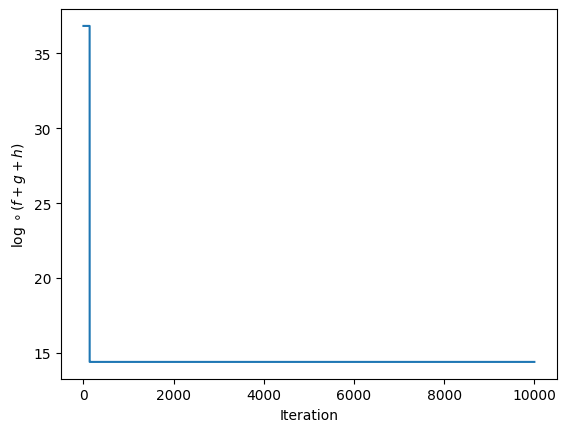

Sum of squares of difference: 2.5590175912859967e-12


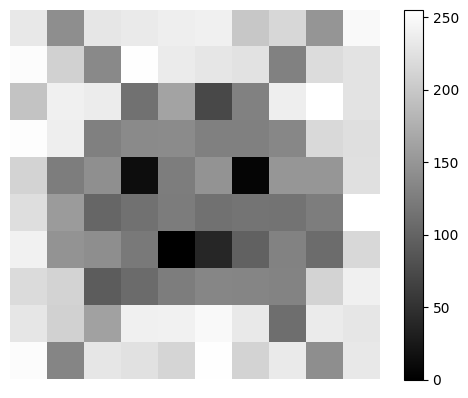

In [194]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 200
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


f1: 0, f2: 10144500.0, g: 1e+16, h: 543440.4999999999
f1: 0, f2: 5507174.999999999, g: 1e+16, h: 490455.0512499999
f1: 0, f2: 6871315.0, g: 1e+16, h: 442635.6837531248
f1: 0, f2: 6694613.25, g: 1e+16, h: 399478.7045871953
f1: 0, f2: 6420818.440625, g: 1e+16, h: 360529.5308899438
f1: 0, f2: 6150914.09046875, g: 1e+16, h: 325377.9016281742
f1: 0, f2: 5920698.221117187, g: 1e+16, h: 293653.55621942726
f1: 0, f2: 5686779.12380586, g: 1e+16, h: 265022.33448803314
f1: 0, f2: 5470036.0120974025, g: 1e+16, h: 239182.6568754499
f1: 0, f2: 5294107.457978438, g: 1e+16, h: 215862.34783009344
f1: 0, f2: 5143411.0617437055, g: 1e+16, h: 194815.76891665938
f1: 0, f2: 4981926.588002827, g: 1e+16, h: 175821.2314472851
f1: 0, f2: 4867518.2277004365, g: 1e+16, h: 158678.66138117475
f1: 0, f2: 4754350.215108852, g: 1e+16, h: 143207.49189651027
f1: 0, f2: 4642477.532263155, g: 1e+16, h: 129244.7614366005
f1: 0, f2: 4529435.876631863, g: 1e+16, h: 116643.39719653197
f1: 0, f2: 4433933.845673128, g: 1e+16, h

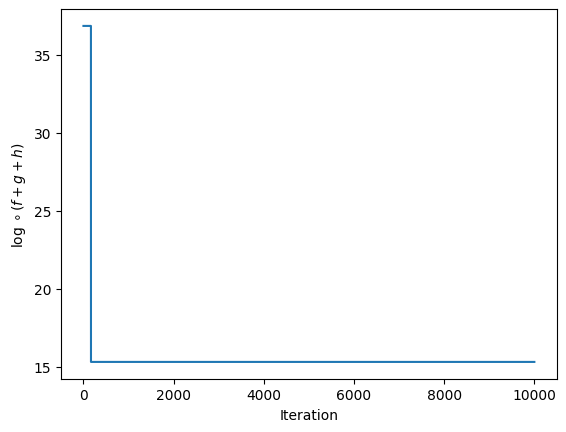

Sum of squares of difference: 2.5590175912859967e-12


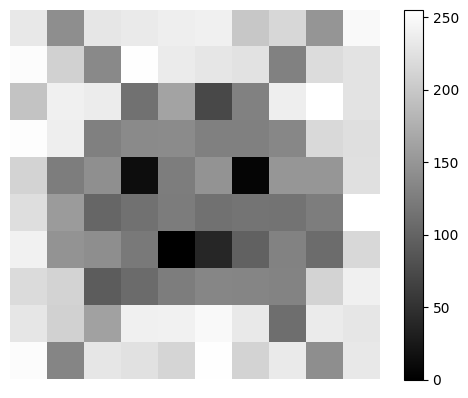

In [195]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 500
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=10000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


The penalty on the constraint represented by $g$ vanished at the end of the iterations. We tried increasing $\gamma$ gradually to prioritize penalty on $\|Fx\|$ over $\dfrac{1}{2}\|x-b\|^2$. Note that $\gamma > 256$ all impacts similarly on $\mathrm{prox}_{f_2}$. However, it did not succeed. The algorithm always minimizes $h$ eventually over $f_2$.

We try dividing $h$ by a factor to reduce its impact. This makes $f_2$ to be prioritized more on minimization.

In [214]:
h = lambda x: norm(x[:100] - b, 2)**2/2
grad_h = lambda x: np.vstack([x[:100] - b, np.zeros((200, 1))])/500

f1: 0, f2: 2436500.0, g: 1e+16, h: 544135.5000000002
f1: 0, f2: 1474668.69, g: 1e+16, h: 544026.6783413552
f1: 0, f2: 1568537.7831179998, g: 1e+16, h: 543917.8784459536
f1: 0, f2: 1569806.4993526882, g: 1e+16, h: 543809.1003094431
f1: 0, f2: 1570063.159922692, g: 1e+16, h: 543700.3439274725
f1: 0, f2: 1570138.1323867606, g: 0, h: 543591.6092956903
f1: 0, f2: 1570005.7985735221, g: 0, h: 543482.8964097473
f1: 0, f2: 1569873.4779936648, g: 0, h: 543374.2052652941
f1: 0, f2: 1569741.1706458654, g: 0, h: 543265.5358579832
f1: 0, f2: 1569608.8765288007, g: 0, h: 543156.8881834667
f1: 0, f2: 1569476.5956411478, g: 0, h: 543048.262237399
f1: 0, f2: 1569344.3279815838, g: 0, h: 542939.6580154344
f1: 0, f2: 1569212.0735487854, g: 0, h: 542831.075513228
f1: 0, f2: 1569079.8323414305, g: 0, h: 542722.5147264358
f1: 0, f2: 1568947.6043581965, g: 0, h: 542613.9756507156
f1: 0, f2: 1568815.3895977605, g: 0, h: 542505.4582817252
f1: 0, f2: 1568683.188058801, g: 0, h: 542396.9626151234
f1: 0, f2: 1568

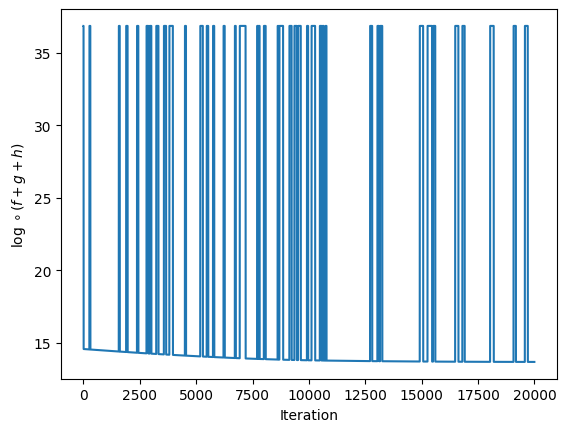

Sum of squares of difference: 141.1820759963309


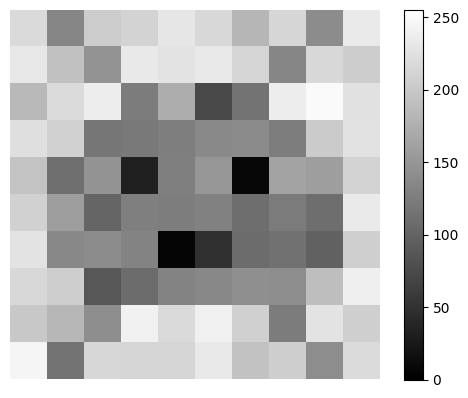

In [217]:
L  = norm(F, 2)
_lambda = 0.05
# Choose bigger gamma for greater penalty on continuous gradient
gamma = 100
x = davis_yin(f, g, h,
          prox_f, prox_g, grad_h,
          max_iter=20000)

print("Sum of squares of difference:", norm(x[:100]-b))

# Display the image
plt.imshow(x[:100].reshape((10, 10)), cmap='gray', vmin=0, vmax=255)  # Grayscale colormap
plt.colorbar()  # Optional: Add a color bar
plt.axis('off')  # Optional: Turn off the axis
plt.show()


This works more efficient that the original $h$, but the result is still not satisfying.